# CNN model with attention block

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import torchmetrics
from torchsummary import summary
import gc
from tqdm import tqdm
import cv2 as cv
import torch
from torch import nn


In [2]:
df = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
df


,Image Index,Patient Gender_F,Patient Gender_M,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,00000003_000.png,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00000003_001.png,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41355,00010698_013.png,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41356,00010698_014.png,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41358,00010698_016.png,1.0,0.0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
41359,00010698_017.png,1.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [3]:
df_finding_labels = df.iloc[:,3:]
df_finding_labels

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41355,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41356,0,0,0,0,0,0,0,0,1,0,0,0,0,0
41358,0,0,0,0,0,0,1,0,1,0,0,1,0,0
41359,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [4]:
# get images
import glob
images_names = np.array(glob.glob('data/images_*/images/*.png'))[df.index]
N = len(images_names)
print("The dataset contains {} images.".format(N))
images_names


The dataset contains 17481 images.


array(['data\\images_001\\images\\00000001_000.png',
       'data\\images_001\\images\\00000001_001.png',
       'data\\images_001\\images\\00000001_002.png', ...,
       'data\\images_005\\images\\00010698_016.png',
       'data\\images_005\\images\\00010698_017.png',
       'data\\images_005\\images\\00010698_018.png'], dtype='<U39')

In [5]:
images_names_train, images_names_test, labels_train, labels_test = train_test_split(images_names, df_finding_labels , test_size = 0.05)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [7]:
# training parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 128
N_EPOCHS = 10

IMG_SIZE = 1024 // 8
N_CLASSES = 14

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)  # 1x1 convolution to reduce channels
        self.softmax = nn.Softmax(dim=2)  # Softmax along spatial dimensions

    def forward(self, x):
        attention_weights = self.conv(x)  # Calculate attention weights
        attention_weights = self.softmax(attention_weights)  # Apply softmax
        attended_features = x * attention_weights  # Apply element-wise multiplication
        return attended_features

# Define your CNN model with attention blocks
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.attention1 = AttentionBlock(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.attention2 = AttentionBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.attention3 = AttentionBlock(128)
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, N_CLASSES)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.attention1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.attention2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.attention3(x)
        x = x.view(-1, 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [9]:
# Create an instance of the CNN model with attention
model = CNNWithAttention().to(device)
summary(model, (1, IMG_SIZE, IMG_SIZE))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3            [-1, 1, 64, 64]              33
           Softmax-4            [-1, 1, 64, 64]               0
    AttentionBlock-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8            [-1, 1, 32, 32]              65
           Softmax-9            [-1, 1, 32, 32]               0
   AttentionBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 1, 16, 16]             129
          Softmax-14            [-1, 1,

In [10]:
# Define the loss function and optimizer
import torch.optim as optim
torch.manual_seed(RANDOM_SEED)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multilabel", num_labels=N_CLASSES)


In [11]:
trainloader = torch.utils.data.DataLoader(list(zip(images_names_train, labels_train.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
                                          
testloader = torch.utils.data.DataLoader(list(zip(images_names_test, labels_test.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)                                          

In [12]:
def train(model, trainloader, testloader, start = 0) : 

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(start, start + N_EPOCHS):  # loop over the dataset multiple times


        running_loss = 0.0
        running_accuracy = 0.0

        with tqdm(trainloader, unit='batch', total = len(trainloader)) as tepoch :
            for X_batch, y_batch in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # get inputs and labels
                labels = y_batch.to(device).float()
                inputs = []
                for x in X_batch : 
                    inputs.append(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)))
                inputs = np.array(inputs)
                inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # get statistics
                l = loss.item()
                running_loss += l  * len(labels) 
                acc = accuracy(outputs, labels).item()
                running_accuracy += acc * len(labels)
                tepoch.set_postfix(loss = l, accuracy = acc)
                time.sleep(1.0)

                # optimize memory
                del inputs
                del labels
                del outputs
                gc.collect()

        # saving model
        path = f"saved_models/att_model_{epoch+1}epochs.pkl"
        torch.save(model.state_dict(), path)
            
        # saving training loss and test loss 
        train_loss.append(running_loss/len(labels_train))
        train_accuracy.append(running_accuracy/len(labels_train))
        test_results = test(model, criterion, testloader)
        test_loss.append(test_results['loss'])
        test_accuracy.append(test_results['accuracy'])

            
    print('Finished Training')


    return {'model' : model, 'training loss' : train_loss, 'training accuracy' : train_accuracy, 'test loss' : test_loss, 'test accuracy' : test_accuracy}

In [13]:
def test(model, criterion, testloader) : 

    running_loss = 0.0
    running_accuracy = 0.0
    
    with tqdm(testloader, unit='batch', total = len(testloader)) as tepoch :
        for X_batch, y_batch in tepoch:
            tepoch.set_description(f"Testing")
            # get inputs and labels
            labels = y_batch.to(device).float()
            inputs = []
            for x in X_batch : 
                inputs.append(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)))
            inputs = np.array(inputs)
            inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            l = loss.item()
            running_loss += l  * len(labels)
            acc = accuracy(outputs, labels).item()
            running_accuracy += acc * len(labels)
    
            tepoch.set_postfix(loss = l, accuracy = acc)
            time.sleep(1)
    
    return {'loss' : running_loss/len(labels_test), 'accuracy' : running_accuracy/len(labels_test), 'predictions' : outputs }

In [14]:
results = train(model, trainloader, testloader)
train_loss = results['training loss'] 
train_accuracy = results['training accuracy']
test_loss = results['test loss']
test_accuracy = results['test accuracy']

Testing: 100%|██████████| 7/7 [00:37<00:00,  5.29s/batch]

Finished Training


In [16]:
test_accuracy

[0.8825306116512843,
 0.8853061228479658,
 0.8886530698367527,
 0.890122460774013,
 0.889469396182469,
 0.8902040850775582,
 0.8898775455611093,
 0.8892244751112802,
 0.890693883555276,
 0.889795928478241]

In [41]:
def plot_stats(title, train_loss, train_accuracy, test_loss, test_accuracy):

    epochs = np.arange(1,len(train_loss)+1)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(title)
    
    ax1.plot(epochs, train_loss, label = 'Training loss')
    ax1.plot(epochs, test_loss, label = 'Testing loss')
    ax1.legend(loc ='upper left')
    ax1.set(xlabel = 'epochs', ylabel = 'loss')
    ax1.set_title('Training and testing loss')

    ax2.plot(epochs, train_accuracy, label = 'Training accuracy') 
    ax2.plot(epochs, test_accuracy, label = 'Test accuracy')
    ax1.legend(loc ='upper left')
    ax1.set(xlabel = 'epochs', ylabel = 'accuracy')
    ax2.set_title('Training and testing accuracy')


    plt.show()

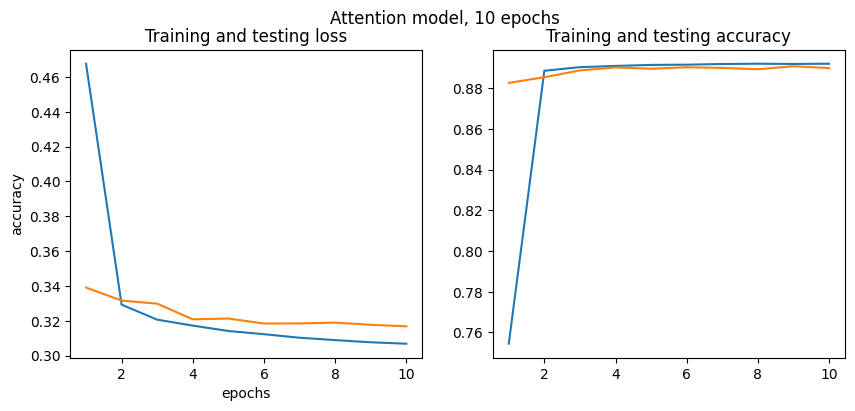

In [42]:
plot_stats('Attention model, 10 epochs', train_loss, train_accuracy, test_loss, test_accuracy)